In [3]:
using Pkg; Pkg.activate("..")
using Base.Threads: @spawn
Threads.nthreads()

  Activating project at `c:\Users\Mantas\.julia\dev\PRONTO.jl`


32

In [4]:
using DifferentialEquations
using LinearAlgebra
using Colors
# using ColorSchemes
set_alpha(CLR::T, alpha) where {T} = coloralpha(T)(CLR.r, CLR.g, CLR.b, alpha)

In [68]:
# interactive, standalone window
using GLMakie
GLMakie.activate!()

In [71]:
# inline plots
using CairoMakie
CairoMakie.activate!(type = "png")
CairoMakie.activate!(type = "svg")

In [70]:
clr_bg = parse(RGBAf, "#272822") # background
clr_mg = parse(RGBAf, "#8E8A73") # mid-ground
clr_fg = :white # fg

clr_set = [
    parse(RGBAf, "#0072BD"), # blue
    parse(RGBAf, "#D95319"), # orange/red
    parse(RGBAf, "#EDB120"), # yellow
    parse(RGBAf, "#7E2F8E"), # purple
    parse(RGBAf, "#009E73FF"), # teal
]

set_theme!(Theme(
    resolution = (1500, 1000),
    textcolor = :white,
    linewidth = 3,
    fontsize = 16,
    font = "Inter",
    color = clr_fg,
    palette = (
        color = clr_set,
    ),
    markercolor = :white,
    backgroundcolor = clr_bg,
    Axis = (
        backgroundcolor = clr_bg,
        xgridcolor = clr_mg,
        ygridcolor = clr_mg, 
        topspinecolor = clr_mg, 
        rightspinecolor = clr_mg,
        leftspinecolor = clr_mg, 
        bottomspinecolor = clr_mg,
        xtickcolor = clr_mg,
        ytickcolor = clr_mg,
    ),
))


In [58]:
## -------------------- plotting helper functions --------------------- ##

function phi2xy(ϕ, i)
    x = -l*sum(sin.(ϕ[1:i]))
    y = l*sum(cos.(ϕ[1:i]))
    return x, y
end

function phis2points(ϕvec)
    return [Point2f(phi2xy(ϕvec, i)) for i=1:N]
end

function colortomap(color, len)
    # Colors.lsequential_palette(color.h, )
    cmap = range(RGB(1.,1.,1.), stop=color, length=len)
    return cmap
end

function kinetic(x)
    ϕ = x[1:N]
    ϕd = x[N+1:end]
    T = 0
    for i = 1:N
        T += 1/2 * l^2 * m[i] * sum(sum([ϕd[j] * ϕd[k] * cos(ϕ[j]-ϕ[k]) for j = 1:i, k=1:i]))
    end
    return T
end

function potential(x)
    ϕ = x[1:N]
    V = 0
    for i = 1:N
        V += m[i] * g * l * sum([cos(ϕ[j]) for j = 1:i])
    end
    return V
end

function ϕdϕ(x)
    n = Int(length(x)/2)
    return (x[1:n], x[n+1:end])
end

function getϕ(x)
    n = Int(length(x)/2)
    return x[1:n]
end

getϕ (generic function with 1 method)

In [59]:
# plotting code
function make_plots(x)
    t = x.t[1]:0.01:x.t[end]
    ϕt = [map(tx->x(tx)[ix], t) for ix in 1:N]
    dϕt = [map(tx->x(tx)[ix], t) for ix in N+1:2N]

    fig = Figure()
    axs = Axis[]

    ax = Axis(fig[1,1]; title="ϕ(t)")
    push!(axs, ax)
    for ϕ in ϕt
        lines!(ax, t, ϕ)
    end

    ax = Axis(fig[2,1]; title="dϕ(t)")
    push!(axs, ax)
    for dϕ in dϕt
        lines!(ax, t, dϕ)
    end

    ax = Axis(fig[1,2]; title="G(t)")
    push!(axs, ax)
    for ix in 1:N
        lines!(ax, t, map(tx->G(x(tx)[1:N])[ix], t))
    end

    # map(tx->C(ϕdϕ(x(tx))...), t)
    ax = Axis(fig[2,2]; title="C(t)")
    push!(axs, ax)
    for ix in 1:N
        lines!(ax, t, map(tx->C(ϕdϕ(x(tx))...)[ix], t))
    end

    # @. potential(getϕ(x(t)))
    ax = Axis(fig[1:2,3]; title="energy")
    push!(axs, ax)
    lines!(ax, t, @. potential(x(t)))
    lines!(ax, t, @. kinetic(x(t)))
    lines!(ax, t, @. potential(x(t)) + kinetic(x(t)))
    
    display(fig)
    return (fig, axs)
end

make_plots (generic function with 1 method)

In [56]:
## ---------------------------- build ODE ------------------------------ ##

# parameters
g = 9.8
l = 1
N = 2
# m = [1, 20, 1, 1]
m = ones(N)
T = t -> zeros(N)

tspan = (0.0, 40.0)
θ₀ = zeros(N)
θ₀[N] = π/2
θd₀ = zeros(N)

# dynamics
# mass matrix M:
U = UpperTriangular(ones(N,N))
L = LowerTriangular(ones(N,N))
Linv = inv(L)
v1 = ones(N)

# ℳ =  (U * m) .* I(N)
ℳvec = (U * m) 
ℳ = [ℳvec[ max(i,j)] for i in 1:N, j in 1:N]
𝒞 = ϕ -> [cos(ϕ[i] - ϕ[j]) for i in 1:N, j in 1:N]
M = ϕ -> l^2 .* ℳ .* 𝒞(ϕ)

# coriolis vector C:
𝒮 = ϕ -> [sin(ϕ[i] - ϕ[j]) for i in 1:N, j in 1:N]
C = (ϕ, ϕd) -> l^2 .* ℳ .* 𝒮(ϕ) .* (v1*ϕd' - 2ϕd*v1') * ϕd

# body force vector G:
G = ϕ -> @. -g*l*ℳvec*sin(ϕ)
# G = ϕ -> g.*l.*ℳvec .* sin.(ϕ)


# ODE solver formulation:
function f!(dx, x, T, t)
    # L: θ -> ϕ, Linv: ϕ -> θ
    θ = x[1:N]; θd = x[N+1:end]
    ϕ = L * θ
    ϕd = L * θd
    θdd = Linv*inv(M(ϕ)) * (-C(ϕ, ϕd) - G(ϕ) + Linv*T(t))
    dx[1:N] = θd; dx[N+1:end] = θdd
end

function fϕ!(dx, x, T, t)
    # x = [ϕ,dϕ], dx = [dϕ,ddϕ]
    ϕ = x[1:N]
    dϕ = dx[1:N] .= x[N+1:end]
    dx[N+1:end] .= inv(M(ϕ)) * (-C(ϕ, dϕ) - G(ϕ) + Linv*T(t))
end

fϕ! (generic function with 1 method)

In [66]:
## ---------------------------- solve ODE ------------------------------ ##

# x = solve(ODEProblem(fϕ!, [θ₀; θd₀], tspan, T), Rosenbrock23()) # matlab ode23s
# x = solve(ODEProblem(fϕ!, [θ₀; θd₀], tspan, T), TRBDF2())
x = solve(ODEProblem(fϕ!, [θ₀; θd₀], tspan, T), BS3()) # matlab ode23


retcode: Success
Interpolation: 3rd order Hermite
t: 1869-element Vector{Float64}:
  0.0
  0.00010197589645454272
  0.000707777346726025
  0.0017416914601285217
  0.0031669960222119146
  0.00511082778219664
  0.0075379035107694895
  0.010479008594899527
  0.01389461507884139
  0.017775901103444916
  ⋮
 39.735454173929185
 39.7583044781693
 39.783917723826235
 39.812744929473645
 39.84533660729549
 39.88241401434881
 39.92511498020338
 39.971544531111086
 40.0
u: 1869-element Vector{Vector{Float64}}:
 [0.0, 1.5707963267948966, 0.0, 0.0]
 [4.327439803760109e-16, 1.5707963777504055, 2.5461544777809004e-11, 0.0009993637852545197]
 [1.23662543804053e-12, 1.570798781443882, 8.512983746596692e-9, 0.006936217997936328]
 [5.267913906048011e-11, 1.5708111908916942, 1.2685383071696267e-7, 0.017068576311433575]
 [5.930212252896686e-10, 1.5708454731275598, 7.626534446287355e-7, 0.03103656106198842]
 [4.05591761992391e-9, 1.570924317542314, 3.2051356782140203e-6, 0.05008611275384391]
 [1.92691404319

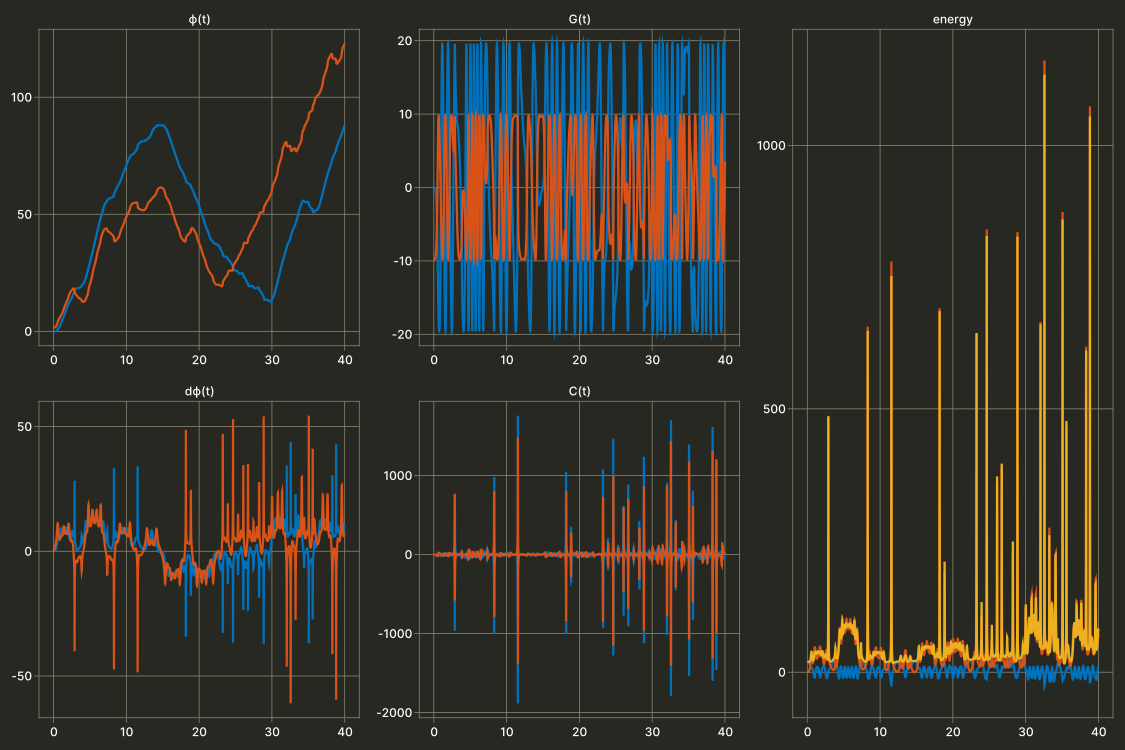

In [72]:
make_plots(x);